# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.lmnp_transformer import *

In [8]:
path = Path('../../data/midi/v13/piano_duet/')

## Single Stream Encoding

In [9]:
config = v13s_config(path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 256,
 'd_head': 32,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 0,
 'bos_idx': 2,
 'sep_idx': 1,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 280,
 'single_stream': True}

## Fastai Learner

In [10]:
data = load_music_data(path, cache_name='tmp/sample', **config)

In [11]:
learn = music_model_learner(data, config)

Sep_idx: 1


In [13]:
xb,yb = data.one_batch(cpu=False)

In [14]:
xb.shape, yb.shape

(torch.Size([16, 256]), torch.Size([16, 256]))

In [17]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [18]:
learn.validate()

[5.9432626, tensor(0.)]

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time


## Prediction

In [ ]:
    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
                decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text`."
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb,yb = self.data.one_item(text)
        new_idx = []
        for _ in range(n_words): #progress_bar(range(n_words), leave=False):
            res = self.pred_batch(batch=(xb,yb))[0][-1]
            #if len(new_idx) == 0: self.model[0].select_hidden([0])
            if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            new_idx.append(idx)
            xb = xb.new_tensor([idx])[None]
        return text + sep + sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

    def beam_search(self, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text` using beam search."
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb, yb = self.data.one_item(text)
        nodes = None
        xb = xb.repeat(top_k, 1)
        nodes = xb.clone()
        scores = xb.new_zeros(1).float()
        with torch.no_grad():
            for k in progress_bar(range(n_words), leave=False):
                out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
                if no_unk: out[:,self.data.vocab.stoi[UNK]] = -float('Inf')
                values, indices = out.topk(top_k, dim=-1)
                scores = (-values + scores[:,None]).view(-1)
                indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
                sort_idx = scores.argsort()[:beam_sz]
                scores = scores[sort_idx]
                nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]
                self.model[0].select_hidden(indices_idx[sort_idx])
                xb = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx][1:] ], sep=None)))


In [25]:
class configview(object):
    def __init__(self, d):
        self.__dict__ = d

In [26]:
cv = configview(config)

In [42]:
xb.shape

torch.Size([1, 280])

In [43]:

def beam_search(self, xb:Tensor, n_words:int, top_k:int=10, beam_sz:int=10, temperature:float=1.,
                ):
    "Return the `n_words` that come after `text` using beam search."
    ds = self.data.single_dl.dataset
    self.model.reset()
    
    xb_length = xb.shape[-1]
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    
    nodes = None
    xb = xb.repeat(top_k, 1)
    nodes = xb.clone()
    scores = xb.new_zeros(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
#             if no_unk: out[:,self.data.vocab.stoi[UNK]] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                            indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            self.model[0].select_hidden(indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    if temperature != 1.: scores.div_(temperature)
    node_idx = torch.multinomial(torch.exp(-scores), 1).item()
    return [i.item() for i in nodes[node_idx][xb_length:] ]


In [44]:
out, nodes = beam_search(learn, xb, n_words=30); out

[134,
 134,
 134,
 135,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 135,
 134,
 134,
 134,
 134,
 134,
 134,
 134,
 1,
 134,
 134]

In [77]:
def predict(self, xb:Tensor, n_words:int=1,
            temperature:float=1., min_p:float=None, min_bars=4):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model.mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    yb = torch.ones_like(xb)
    new_idx = []
    
    running_ps = 1.0
    timesteps = []
    sep_count = 0
    
    for i in progress_bar(range(n_words), leave=True):
        
        running_ps = (n_words * 2 - i) / (n_words * 2)
        
        res = self.pred_batch(batch=(xb,yb))[0][-1]
        #if len(new_idx) == 0: self.model[0].select_hidden([0])
        if min_p is not None: 
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.
                
        # bar = 16 beats
        if (sep_count // 16) <= min_bars: res[cv.bos_idx] = 0.
            
        if temperature != 1.: res.pow_(1 / (temperature * running_ps))
        idx = torch.multinomial(res, 1).item()
        
        
        if new_idx and new_idx[-1]==cv.sep_idx: 
            duration = (idx - 3 - 130) + 1
            sep_count += duration
#                 print('Bars', duration, sep_count // 16)

        if idx==cv.bos_idx: 
            print('Predicted BOS token. Returning prediction...')
            break
            
            
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return np.array(new_idx)


In [78]:
out = predict(learn, xb, n_words=50)
# out_s, seed_s = predict(learn, xb, n_words=800, temperatures=(1.0,.5), min_ps=(1/128,0.0))
# out = to_double_stream(out_s)
# seed = to_double_stream(seed_s)

In [75]:
out_2 = to_double_stream(out)

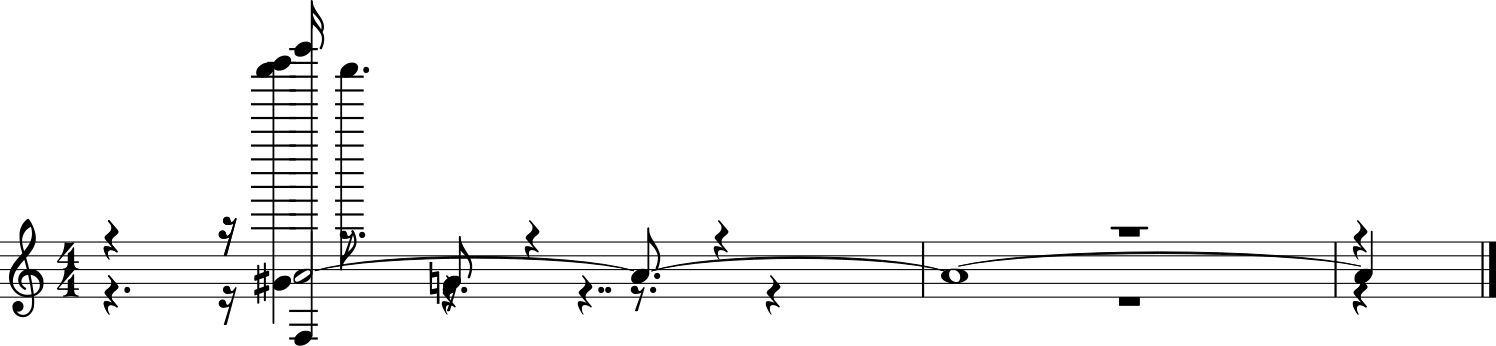

In [76]:
out_stream = npenc2stream(out_2)
out_stream.show()

In [48]:
def predict(self, xb, n_words:int=340, min_bars=4,
            temperatures=(1.4,0.5), min_ps=(1/128,0.0),
            adaptive_ratio=(0.3,0.6,.1)):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model.mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)

    running_ps = [1, 1]

    timesteps = []
    sep_count = 0
    for _ in progress_bar(range(n_words), leave=True):
        comps = []
        outputs = self.pred_batch(batch=(xb,yb))
        for idx,item in enumerate(outputs): #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            min_p,temperature = min_ps[idx], temperatures[idx]
#                 if idx == 0: print('Items over p:', (res >= min_p).float().sum(), res.shape)
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[cv.bos_idx] = 0.

            res_temp = res.pow(1 / (temperature * running_ps[idx]))
            mult_idx = torch.multinomial(res_temp, 1)

            if adaptive_ratio is not None:
                mult_p = res[mult_idx].item() * adaptive_ratio[0]
                running_p = running_ps[idx] * adaptive_ratio[1]
                other_p = running_ps[(idx+1)%len(running_ps)] * adaptive_ratio[2]
                running_ps[idx] = mult_p + running_p + other_p
#             val,idx = torch.topk(res, 1)
            comps.append(mult_idx.squeeze().to(xb.device))
        comps = torch.stack(comps, dim=-1)

        if cv.sep_idx is not None and (timesteps and timesteps[-1]==cv.sep_idx): 
            duration = (mult_idx.item() - 3 - 130) + 1
            sep_count += duration
#                 print('Bars', duration, sep_count // 16)

        if cv.bos_idx is not None and (comps==cv.bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(comps.cpu().numpy())
        xb = comps.clone().detach()[None,None] # don't use timesteps. use it's own memory instead

    self.model.mask = True
    return np.array(timesteps), seed.squeeze()



In [28]:
data_dir = 'data/midi/v13/'
source_dir = 'piano_duet'
file_path = Path('../../')

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,7,8,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('canon')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory']; results.head()

,artist,ht_time_signature,ht_offset,song_url,midi,source,genres,section,midi_title,md5,ht_bpm,title,ht_mode,numpy,parts,ht_key,mxl
1062,johann-sebastian-bach,4.0,-3.0,https://www.hooktheory.com/theorytab/view/joha...,midi_sources/hooktheory/pianoroll/j/johann-seb...,hooktheory,Classical,instrumental,Canon 1 a 2,c1e4271a0f4a68ed4a3a9cf58a36ff4f,128.0,canon-1-a-2,6.0,piano_duet/hooktheory/pianoroll/j/johann-sebas...,instrumental,C,NaN
1491,johann-pachelbel,4.0,-2.0,https://www.hooktheory.com/theorytab/view/joha...,midi_sources/hooktheory/pianoroll/j/johann-pac...,hooktheory,NaN,pre-chorus,Canon Prechorus,3c6944b6a2dd648b6c7c8a5f2b0b3c5f,132.0,canon-in-d-major,1.0,piano_duet/hooktheory/pianoroll/j/johann-pache...,"intro,pre-chorus,chorus",D,NaN
1492,johann-pachelbel,4.0,-2.0,https://www.hooktheory.com/theorytab/view/joha...,midi_sources/hooktheory/pianoroll/j/johann-pac...,hooktheory,NaN,chorus,Pachelbel Canon Chorus,ba9c087d394b5f5f00402fbb8a265834,138.0,canon-in-d-major,1.0,piano_duet/hooktheory/pianoroll/j/johann-pache...,"intro,pre-chorus,chorus",D,NaN
1493,johann-pachelbel,4.0,-2.0,https://www.hooktheory.com/theorytab/view/joha...,midi_sources/hooktheory/pianoroll/j/johann-pac...,hooktheory,NaN,intro,Pachelbel Canon in D,9fe819012e091691cb0636484dc9609b,130.0,canon-in-d-major,1.0,piano_duet/hooktheory/pianoroll/j/johann-pache...,"intro,pre-chorus,chorus",D,NaN


In [30]:
idx = 1
file = file_path/data_dir/results.numpy.values[idx]; 
# orig = file_path/data_dir/results.mxl.values[idx];
orig = file_path/data_dir/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v13/piano_duet/hooktheory/pianoroll/j/johann-pachelbel/canon-in-d-major/pre-chorus_key_original.npy'),
 PosixPath('../../data/midi/v13/midi_sources/hooktheory/pianoroll/j/johann-pachelbel/canon-in-d-major/pre-chorus_key_original.mid'))

In [31]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np))[None]
if torch.cuda.is_available(): xb = xb.cuda()

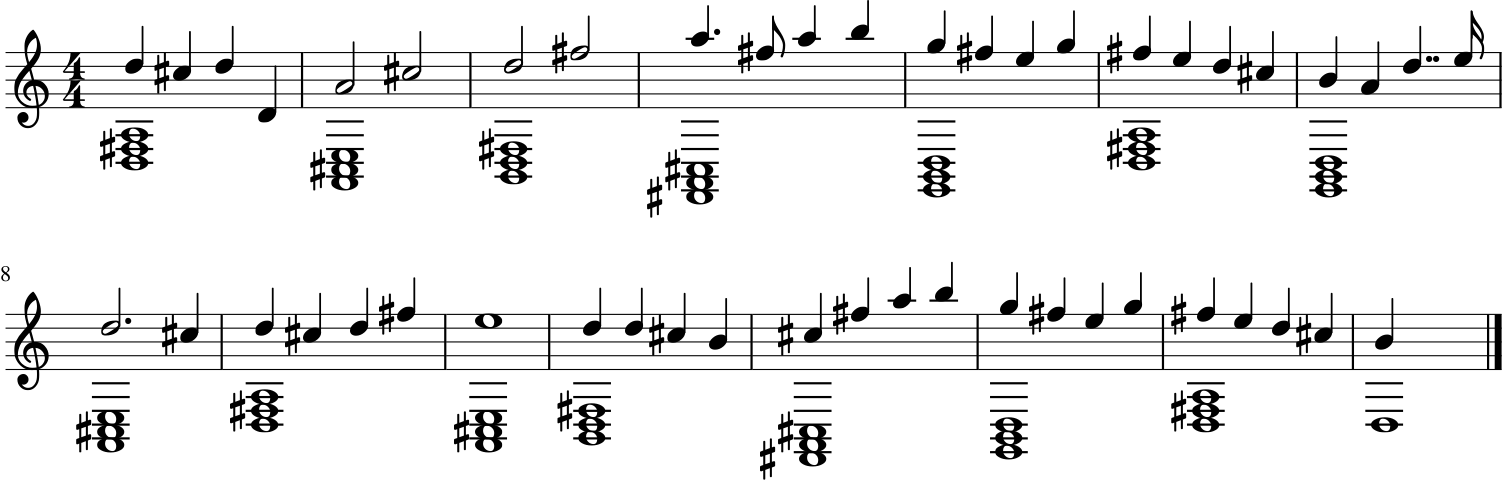

In [32]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

In [49]:
out_s, seed_s = predict(learn, xb, n_words=800, temperatures=(1.0,.5), min_ps=(1/128,0.0))
out = to_double_stream(out_s)
seed = to_double_stream(seed_s)

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: There is no item with probability >= 0.0078125, try a lower value.


IndexError: dimension specified as 0 but tensor has no dimensions

In [50]:
%debug

> <ipython-input-48-6dfb99416476>(28)predict()
     26 
     27             # bar = 16 beats
---> 28             if (sep_count // 16) <= min_bars: res[cv.bos_idx] = 0.
     29 
     30             res_temp = res.pow(1 / (temperature * running_ps[idx]))

ipdb> res.shape
torch.Size([])
ipdb> quit


In [41]:
stream = npenc2stream(out)
stream.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Old Learner

In [10]:
learn = load_learner(data, config)

Sep_idx: 1


In [11]:
learn.validate()

[6.578764, tensor(0.)]

In [17]:
# # clip = 0.5
learn.lr_find(num_it=600)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


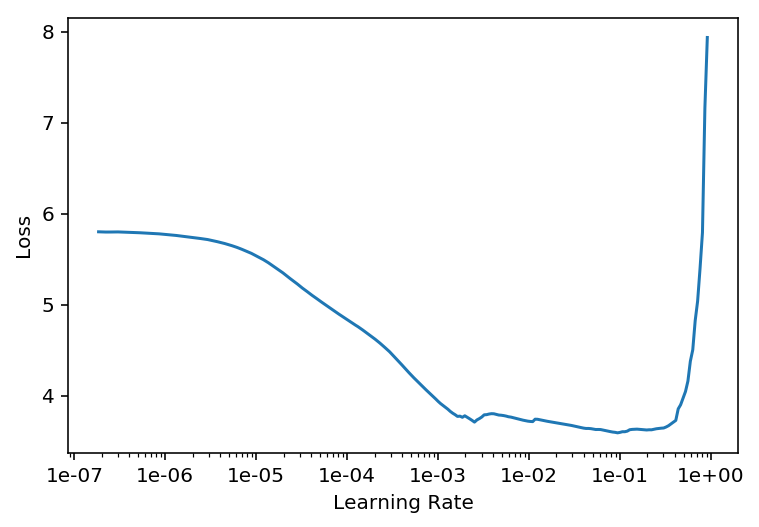

In [12]:
# # clip = 0.5
learn.lr_find(num_it=300)
learn.recorder.plot()

In [12]:
# relu
learn.fit_one_cycle(1, 4e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.875336,1.772942,0.499271,05:28


In [12]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.977311,1.864041,0.477630,05:29


## Double Stream Encoding

In [13]:
config = v10_config(path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 256,
 'd_head': 64,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256}

In [14]:
data = load_data(path, cache_name='tmp/sample', **config)

In [15]:
learn = load_learner(data, config)

In [16]:
learn.validate()

[9.725336, tensor(0.0094)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


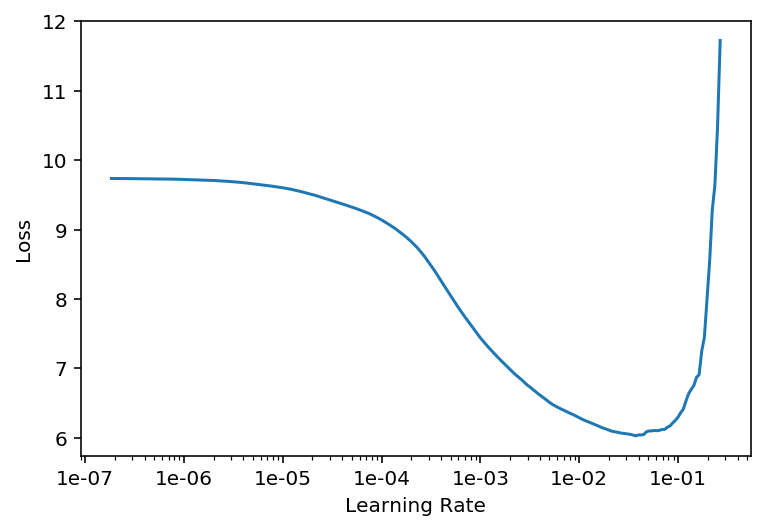

In [17]:
# # clip = 0.5
learn.lr_find(num_it=300)
learn.recorder.plot()

In [12]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.133816,4.030482,0.448240,02:46


In [18]:
# relu
learn.fit_one_cycle(1, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.335164,4.221336,0.428890,02:46


## Prediction

In [13]:
x,y = data.one_batch(cpu=False)

In [14]:
out,seed = learn.predict(x, n_words=100)

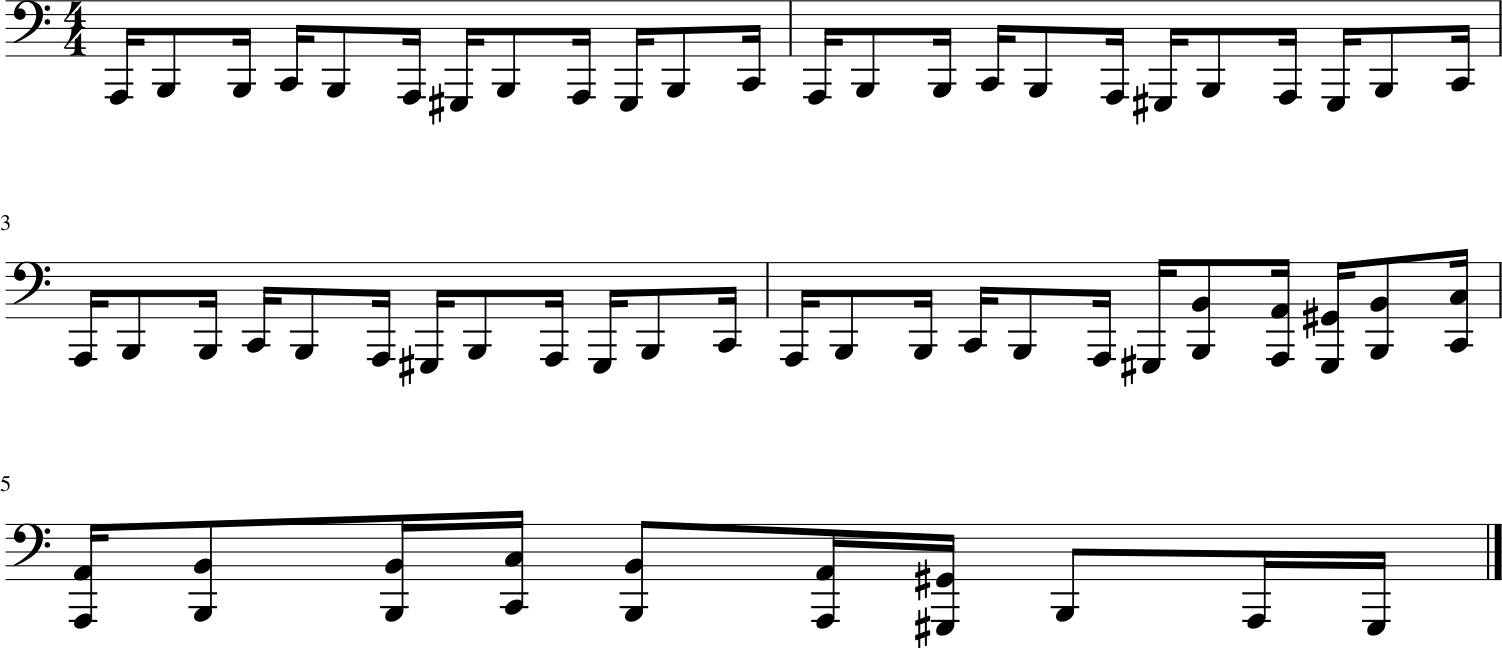

In [20]:
stream = npenc2stream(to_double_stream(seed))
stream.show()

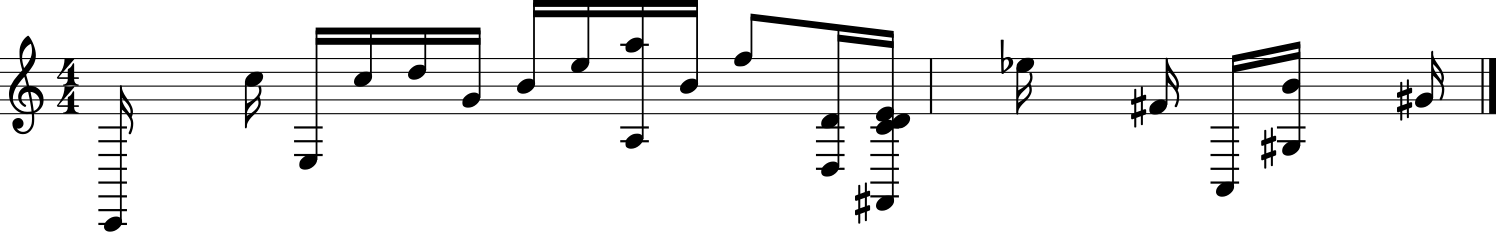

In [21]:
stream = npenc2stream(to_double_stream(out))
stream.show()

In [36]:
# ob = data.one_batch(cpu=False)
# out = learn.model(ob[0])
# out = learn.pred_batch(ob)
# learn.loss_func([c.cuda() for c in out], ob[1])

In [37]:
# # # clip = 0.5
# learn.lr_find(num_it=300)
# learn.recorder.plot()

In [38]:
# learn.to_fp16();

### Run 2

In [39]:
# relu
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.462585,3.509509,0.548042,02:09
1,3.721648,3.308317,0.509911,02:09
2,3.412720,2.950449,0.548208,02:09
3,3.429547,2.876465,0.563198,02:10


In [43]:
# gelu
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,4.343354,3.373704,0.536694,02:18
1,3.574547,3.185786,0.515622,02:17
2,3.417778,2.864015,0.583908,02:17
3,3.374456,2.785271,0.593978,02:17


In [41]:
learn.validate()

[7.566925, tensor(0.2803)]

In [43]:
learn.save('first_run_10ep')

In [46]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,lmnp_accuracy,time
0,1.337372,1.288798,0.932526,14:50
1,1.382319,1.416606,0.927723,14:51
2,1.282228,1.287018,0.932393,14:55
3,1.221084,1.222616,0.935772,14:53
4,1.270180,1.200249,0.937181,14:54


In [42]:
from fastai import basic_train

In [43]:
def predict_func(parts): return [F.softmax(p, dim=-1) for p in parts]

In [44]:
loss_func_name = camel2snake(learn.loss_func.__class__.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func
basic_train._loss_func2activ(learn.loss_func)

<function __main__.predict_func(parts)>

In [45]:
# bos_idx = enc_config.enc_offset+enc_config.bos_idx
bos_idx = VALTBOS

def predict(self, xb, n_words:int=1, temperature:float=1., min_p:float=None, bos_idx:None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    learn.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = get_positions(xb) if BIDX_ALL else []
        outputs = learn.pred_batch(batch=(xb,yb))
        for item in outputs: #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            if min_p is not None: 
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1)
#             val,idx = torch.topk(res, 1)
            bar.append(idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if (bar==bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead
    
    learn.model[0].mask = True
    return timesteps, seed.squeeze()


### From batch

In [46]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [47]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [48]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/intro_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/verse_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/h

In [49]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/intro_key_cmajor.npy')

In [50]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [51]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [52]:
out, seed = predict(learn, xb, n_words=340, temperature=.7, min_p=0.01)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


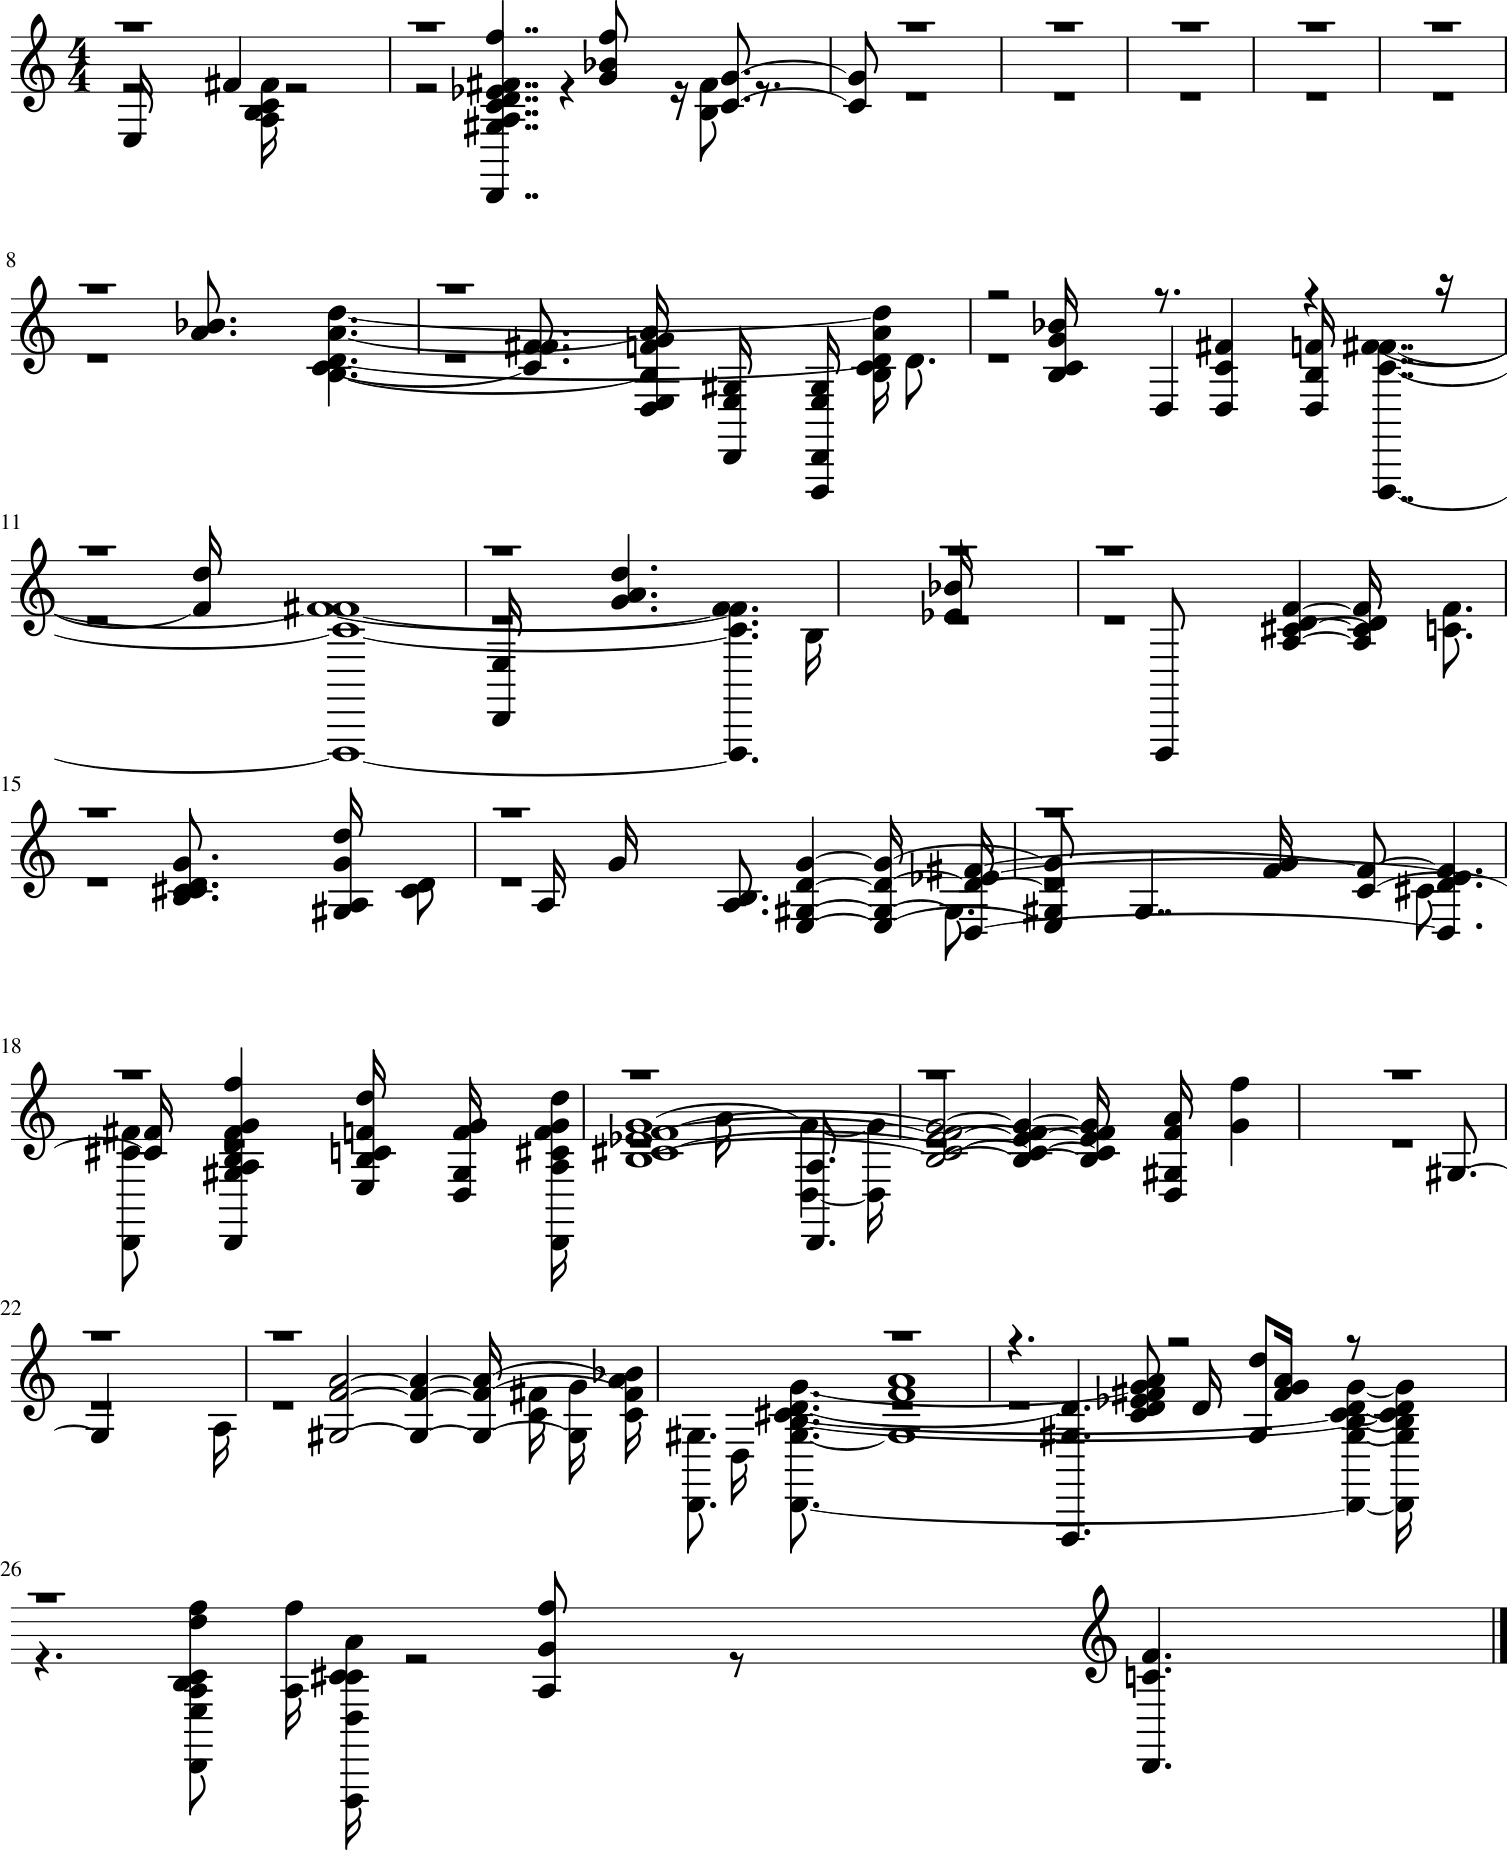

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

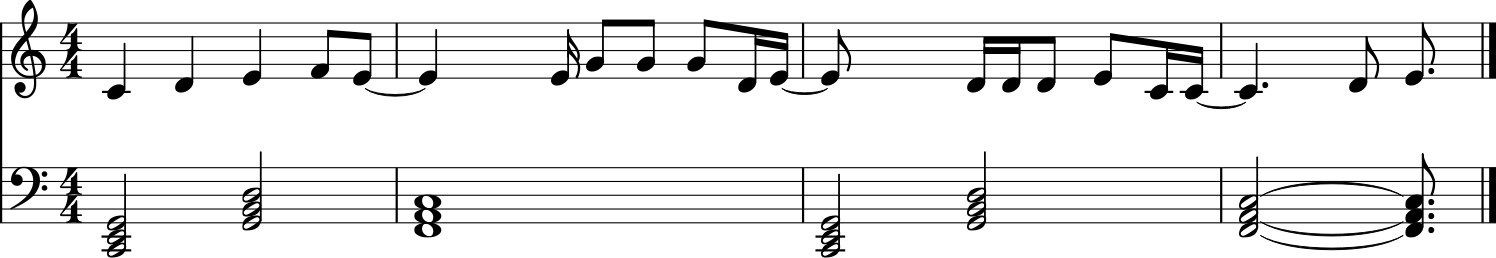

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')